In [1]:
import torch
from models import VisionTransformer, CONFIGS, AutoEncoder, ResNet50, InputEmbed
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F21
import torchvision.transforms as transforms
# from dataset import get_dataloader
from dataset import make_word_img, get_img, get_color
import csv
import pandas as pd
from tqdm import tqdm
import gensim
from visualization import visualize,get_word_img,get_visualization_res
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil
import cv2
from PIL import Image
import pickle

In [2]:
torch.cuda.is_available()

True

In [3]:
MODEL = 'Transformer'
NUM_EPOCHS = 1000
BATCH_SIZE = 64
DEVICE = 'cuda'
EARLY_STOP = True
NUM_LAYER = 4
EARLY_STOP_NUM = 10
MODEL_SIZE = f"head6_layer{NUM_LAYER}"
MODEL_NAME = '1' #ResNet50
LR = 1e-5
SAVE_ROOT = "results_for_wo_one_element"
SAVE_FOLDAR = f'{MODEL}_{MODEL_SIZE}_lr{LR}'
DROP_ELEMENTS = ["char_color"]
ELEMENTS = ["semantic","font_style","char_color","bk_color","height","coord"]
for dp_elemet in DROP_ELEMENTS:
    ELEMENTS.remove(dp_elemet)
    SAVE_FOLDAR += f'_{dp_elemet}'
CONFIGS["title_level_config"]["transformer"]["num_layers"] = NUM_LAYER
def torch_fix_seed(seed=0):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed(0)

In [4]:
torch_fix_seed(seed=0)
drop_elements = ["semantic","font_style","char_color","bk_color","height","coord","char_colorbk_color","heightcoord"]
for i in range(len(drop_elements)):
    name = drop_elements[i]
    print(f"=== drop feat: {name}===")
    df_res = pd.read_csv(f'/workspace/{SAVE_ROOT}/csv/{name}_res.csv')
    # len(df_res[df_res["Category ID"]==df_res['top1_res']])/len(df_res) * 100
    for k in [1,3,5]:
        correct_num = 0
        for i in range(len(df_res)):
            pred_list = [df_res.loc[i,f"top{j}_res"] for j in range(1,k+1)]
            true_label = df_res.loc[i,"Category ID"]
            if true_label in pred_list:
                correct_num += 1
        print(f"top {k} acc.: {correct_num/len(df_res)*100}")

=== drop feat: semantic===
top 1 acc.: 17.05818576075172
top 3 acc.: 32.68883267076256
top 5 acc.: 44.66931694976509
=== drop feat: font_style===
top 1 acc.: 47.19913263462234
top 3 acc.: 67.87134080231297
top 5 acc.: 76.74376581134803
=== drop feat: char_color===
top 1 acc.: 47.162992410552945
top 3 acc.: 68.41344416335382
top 5 acc.: 77.79183230936032
=== drop feat: bk_color===
top 1 acc.: 47.3256234188652
top 3 acc.: 68.77484640404771
top 5 acc.: 77.70148174918684
=== drop feat: height===
top 1 acc.: 48.24719913263462
top 3 acc.: 68.90133718829057
top 5 acc.: 78.37007589447055
=== drop feat: coord===
top 1 acc.: 47.09071196241417
top 3 acc.: 68.05204192265992
top 5 acc.: 77.44850018070112
=== drop feat: char_colorbk_color===
top 1 acc.: 47.21720274665703
top 3 acc.: 67.96169136248645
top 5 acc.: 77.66534152511746
=== drop feat: heightcoord===
top 1 acc.: 46.85580050596314
top 3 acc.: 67.72677990603542
top 5 acc.: 76.65341525117456


=== drop feat: semantic===


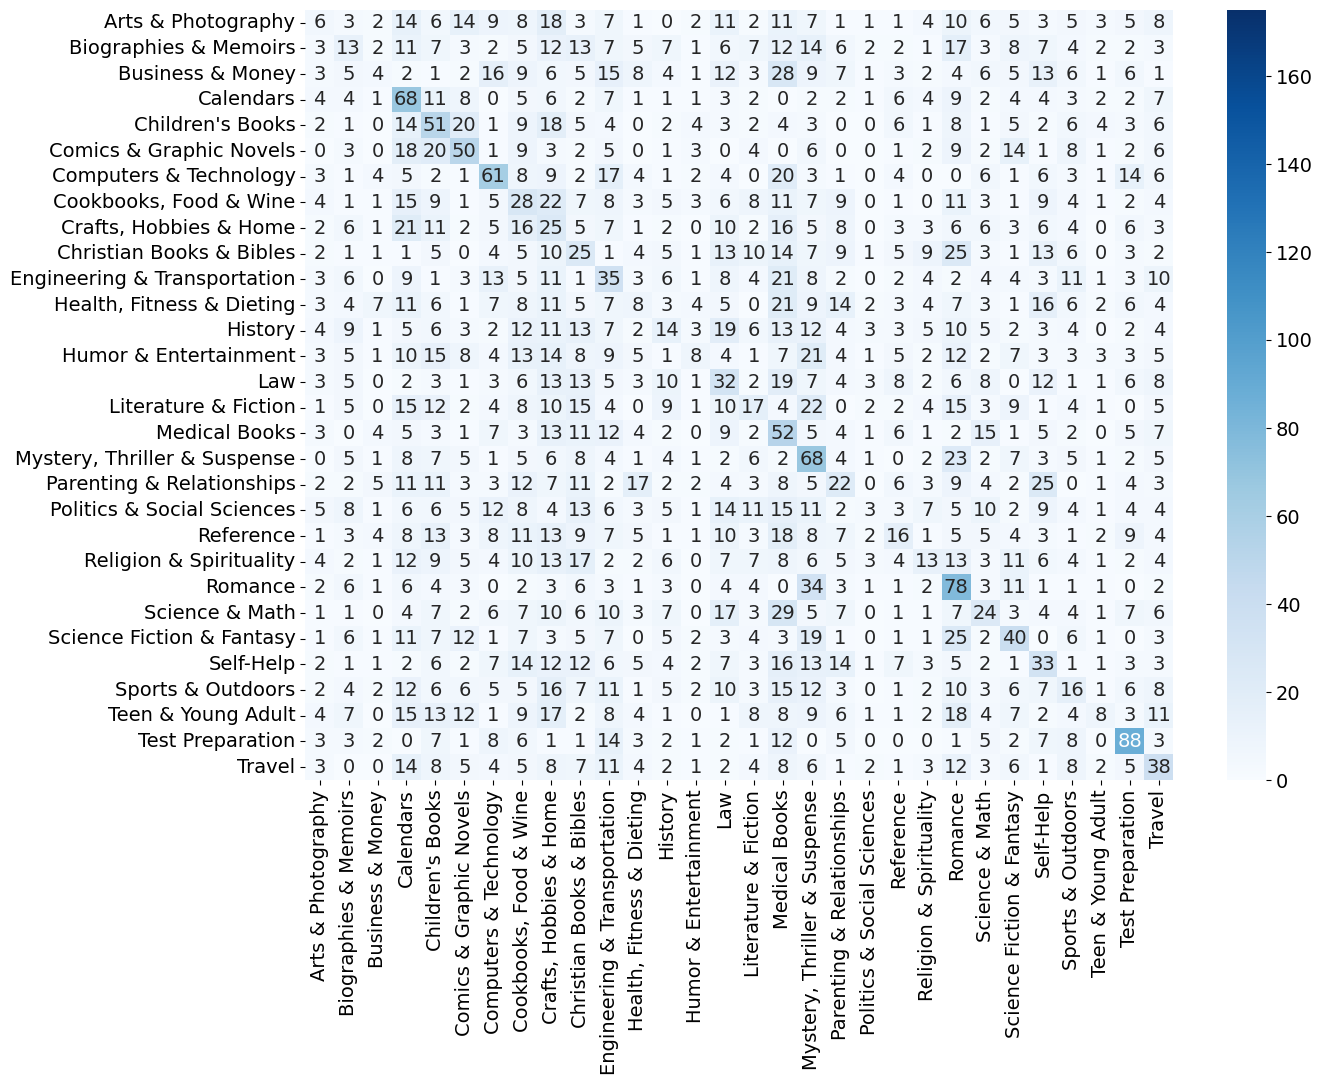

=== drop feat: font_style===


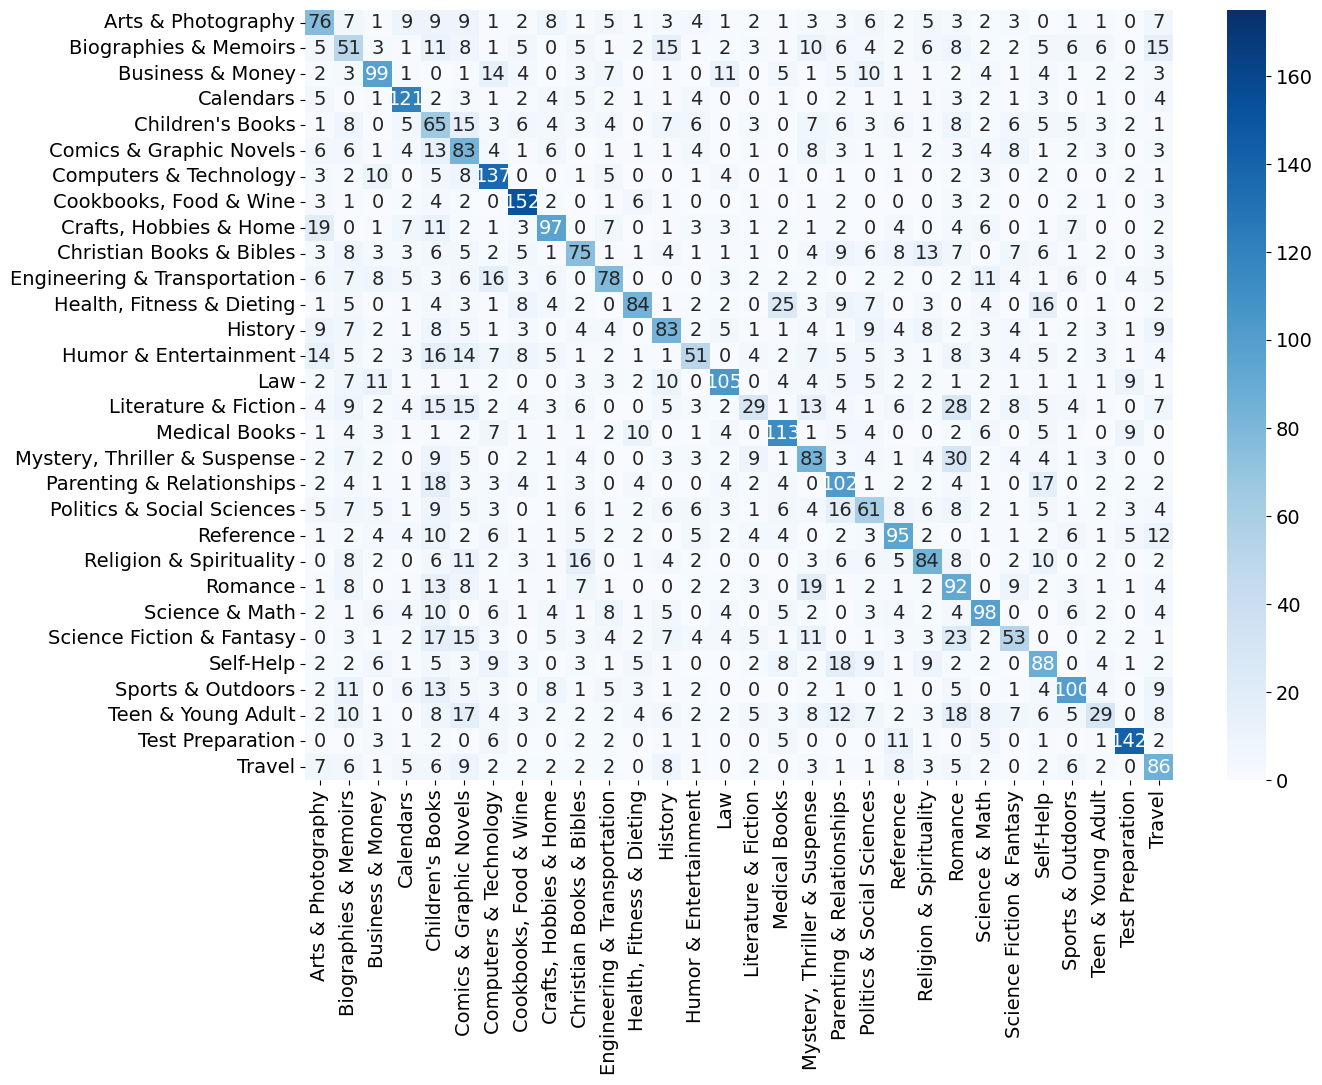

=== drop feat: char_color===


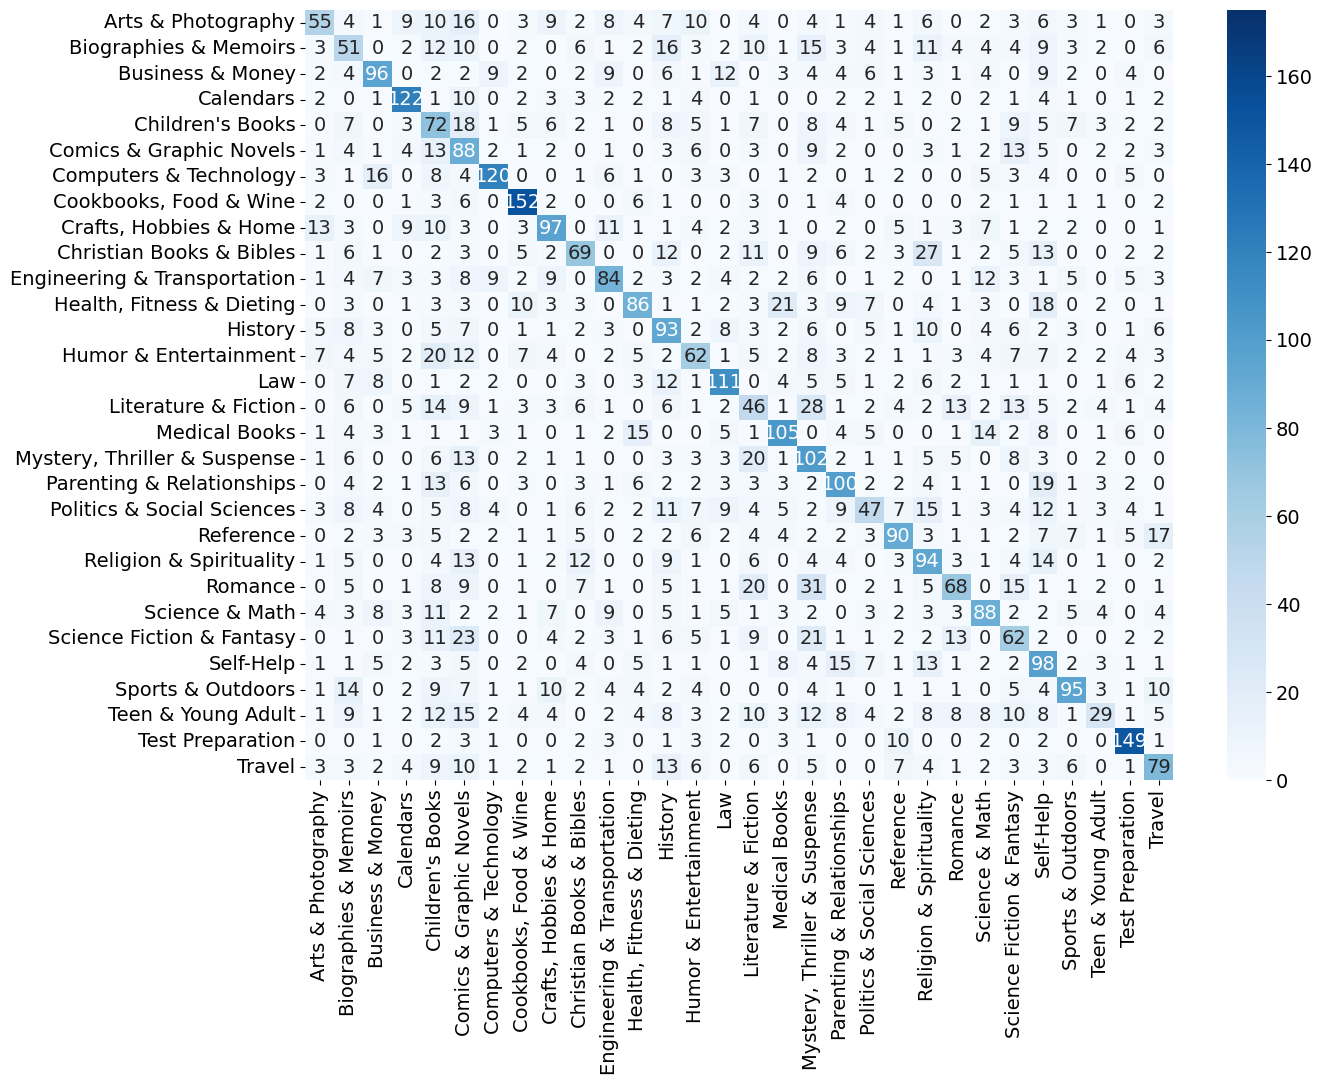

=== drop feat: bk_color===


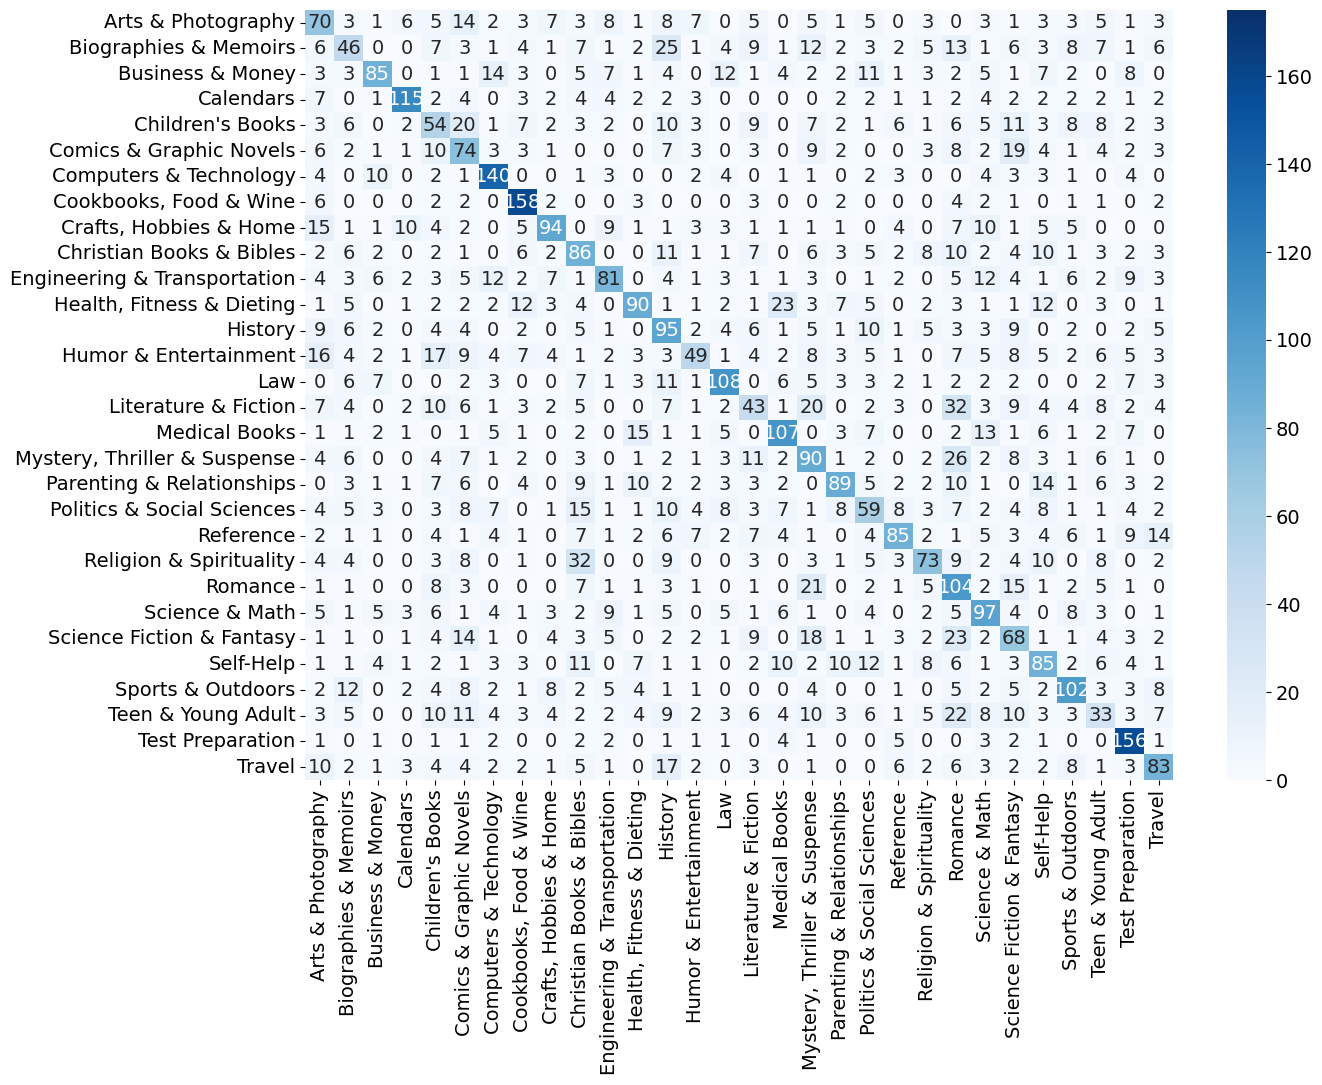

=== drop feat: height===


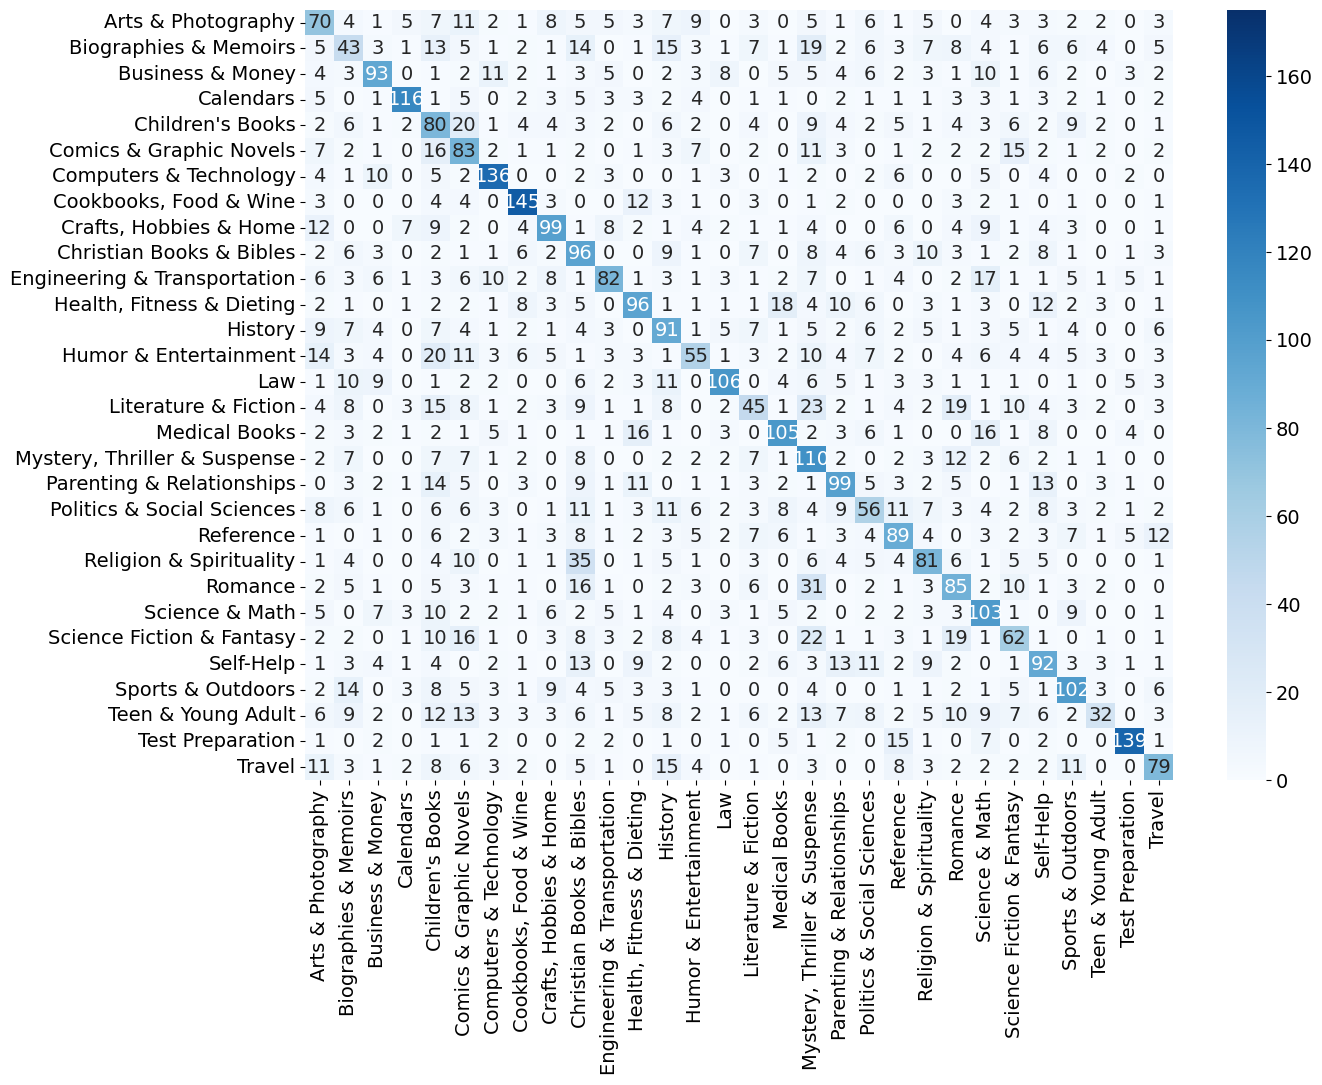

=== drop feat: coord===


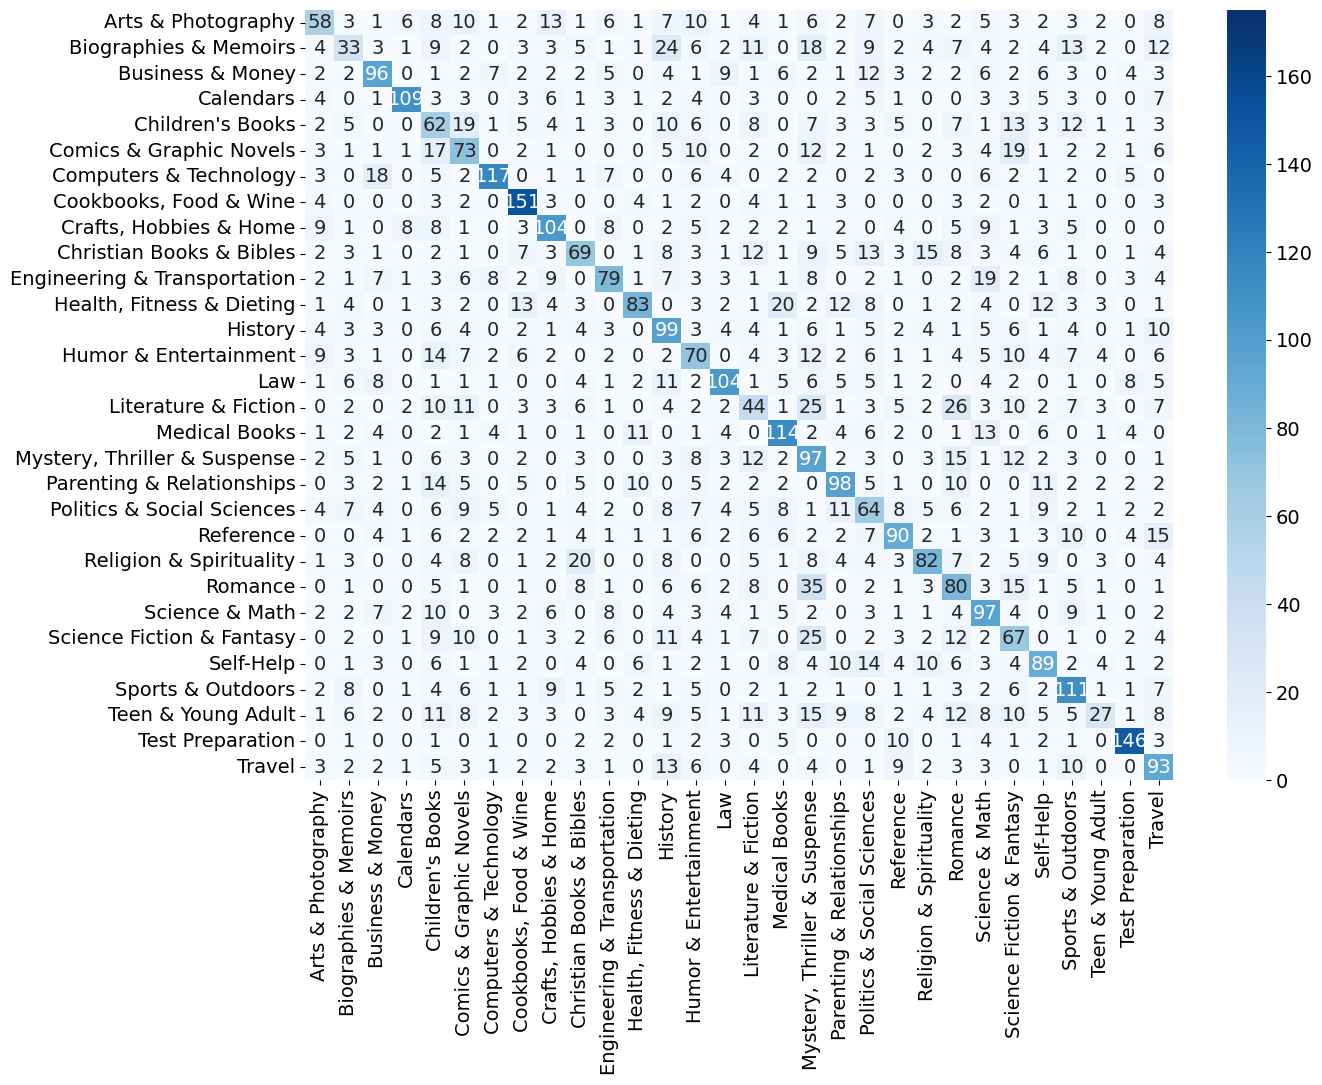

In [5]:
torch_fix_seed(seed=0)
drop_elements = ["semantic","font_style","char_color","bk_color","height","coord"]
for i in range(len(drop_elements)):
    name = drop_elements[i]
    print(f"=== drop feat: {name}===")
    df_res = pd.read_csv(f'/workspace/{SAVE_ROOT}/{name}_res.csv')
    df_tmp = df_res[["Category ID","Category"]]
    df_tmp = df_tmp[~df_tmp.duplicated()]
    y_true = df_res["Category ID"].values
    y_pred = df_res["top1_res"].values
    cm_all = confusion_matrix(y_true, y_pred)
    xtics = df_tmp.sort_values("Category ID")['Category'].values
    max_num = 175
    plt.figure(figsize = (14,10))
    plt.rcParams["font.size"] = 14
    sns.heatmap(cm_all, cmap='Blues',vmax=max_num,vmin=0,xticklabels=xtics,yticklabels=xtics,annot=True,fmt="d")#,annot=True
    plt.show()

In [6]:
drop_elements = ["","font_stylechar_colorbk_colorheightcoord"]
for i in range(len(drop_elements)):
    if i == 0:
        print("=== name: all ===")
    else:
        print("=== name: semantic only ===")
    name = drop_elements[i]
    df_res = pd.read_csv(f'/workspace/{SAVE_ROOT}/{name}_res.csv')
    # len(df_res[df_res["Category ID"]==df_res['top1_res']])/len(df_res) * 100
    for k in [1,3,5]:
        correct_num = 0
        for i in range(len(df_res)):
            pred_list = [df_res.loc[i,f"top{j}_res"] for j in range(1,k+1)]
            true_label = df_res.loc[i,"Category ID"]
            if true_label in pred_list:
                correct_num += 1
        print(correct_num/len(df_res)*100)

=== name: all ===
48.44597036501626
68.90133718829057
78.1713046620889
=== name: semantic only ===
45.46440187929165
67.00397542464763
76.32815323455006


In [7]:
df_res = pd.read_csv(f'/workspace/{SAVE_ROOT}/_res.csv')
for i in range(30):
    category = df_res[df_res["Category ID"]==i]['Category'].values[0]
    total_num = len(df_res[df_res["Category ID"]==i]['Category'])
    true_num = len(df_res[(df_res["Category ID"]==i) & (df_res["Category ID"]==df_res["top1_res"])])
    acc = round(true_num/total_num*100,4)
    print(category, f'{true_num}/{total_num}:', acc)

Arts & Photography 71/176: 40.3409
Biographies & Memoirs 49/187: 26.2032
Business & Money 90/188: 47.8723
Calendars 114/172: 66.2791
Children's Books 76/185: 41.0811
Comics & Graphic Novels 77/171: 45.0292
Computers & Technology 140/189: 74.0741
Cookbooks, Food & Wine 145/189: 76.7196
Crafts, Hobbies & Home 96/185: 51.8919
Christian Books & Bibles 93/186: 50.0
Engineering & Transportation 80/184: 43.4783
Health, Fitness & Dieting 97/188: 51.5957
History 94/187: 50.2674
Humor & Entertainment 60/187: 32.0856
Law 101/187: 54.0107
Literature & Fiction 41/185: 22.1622
Medical Books 105/185: 56.7568
Mystery, Thriller & Suspense 110/189: 58.2011
Parenting & Relationships 98/189: 51.8519
Politics & Social Sciences 55/188: 29.2553
Reference 95/185: 51.3514
Religion & Spirituality 87/184: 47.2826
Romance 86/186: 46.2366
Science & Math 107/183: 58.4699
Science Fiction & Fantasy 62/177: 35.0282
Self-Help 89/189: 47.0899
Sports & Outdoors 108/187: 57.754
Teen & Young Adult 28/186: 15.0538
Test Prep

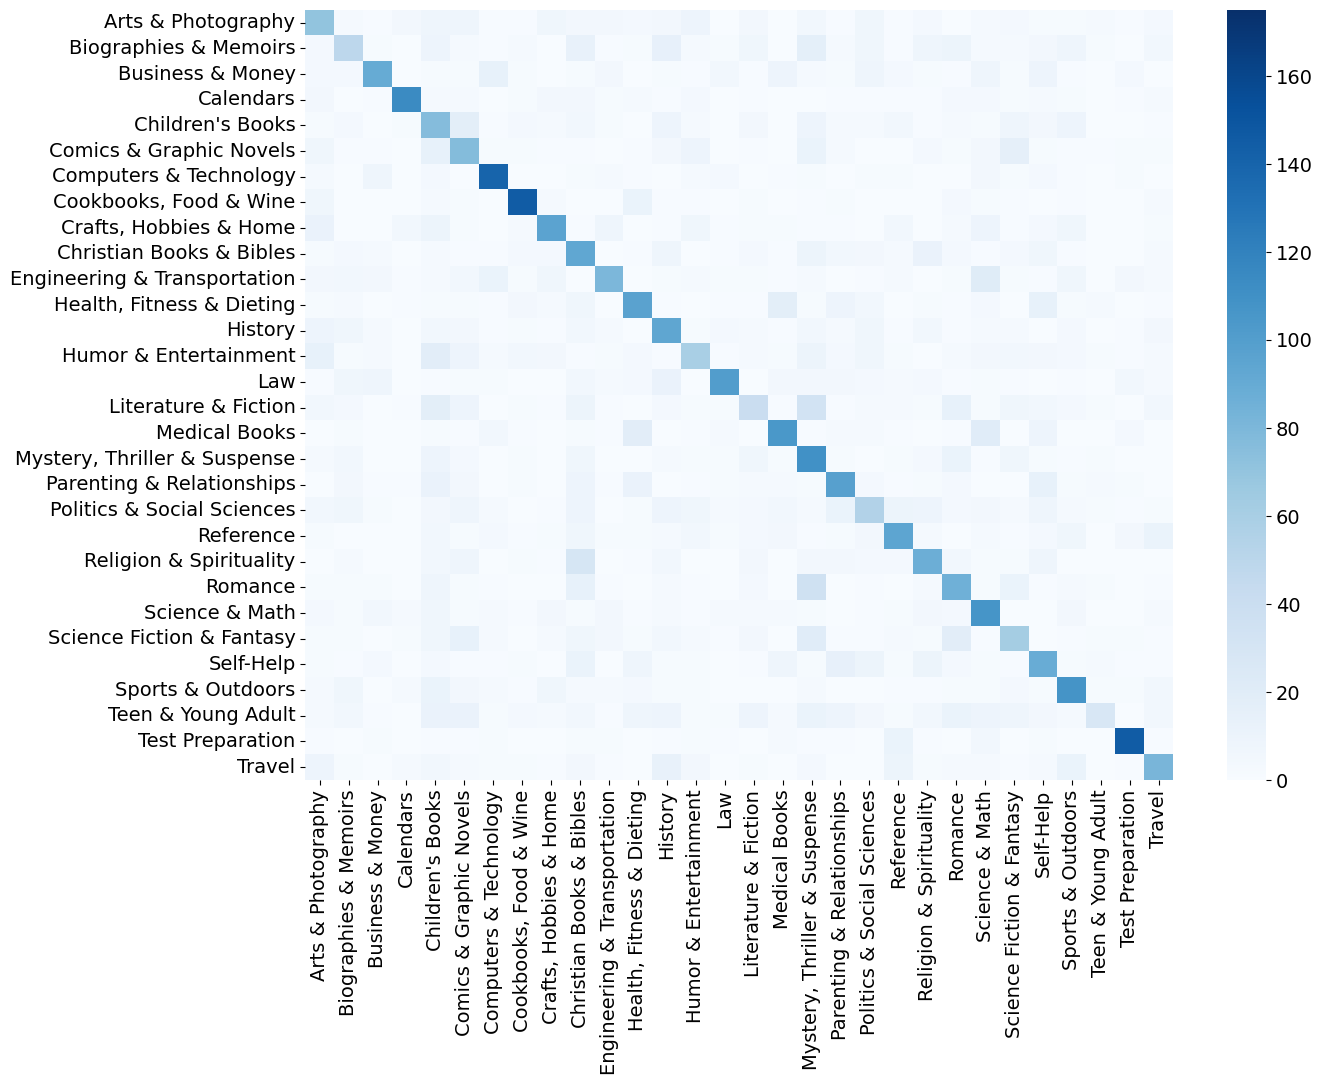

In [8]:
df_res = pd.read_csv(f'/workspace/{SAVE_ROOT}/_res.csv')
df_tmp = df_res[["Category ID","Category"]]
df_tmp = df_tmp[~df_tmp.duplicated()]
y_true = df_res["Category ID"].values
y_pred = df_res["top1_res"].values
cm_all = confusion_matrix(y_true, y_pred)
xtics = df_tmp.sort_values("Category ID")['Category'].values
max_num = 175
plt.figure(figsize = (14,10))
plt.rcParams["font.size"] = 14
sns.heatmap(cm_all, cmap='Blues',vmax=max_num,vmin=0,xticklabels=xtics,yticklabels=xtics)#,annot=True
plt.show()

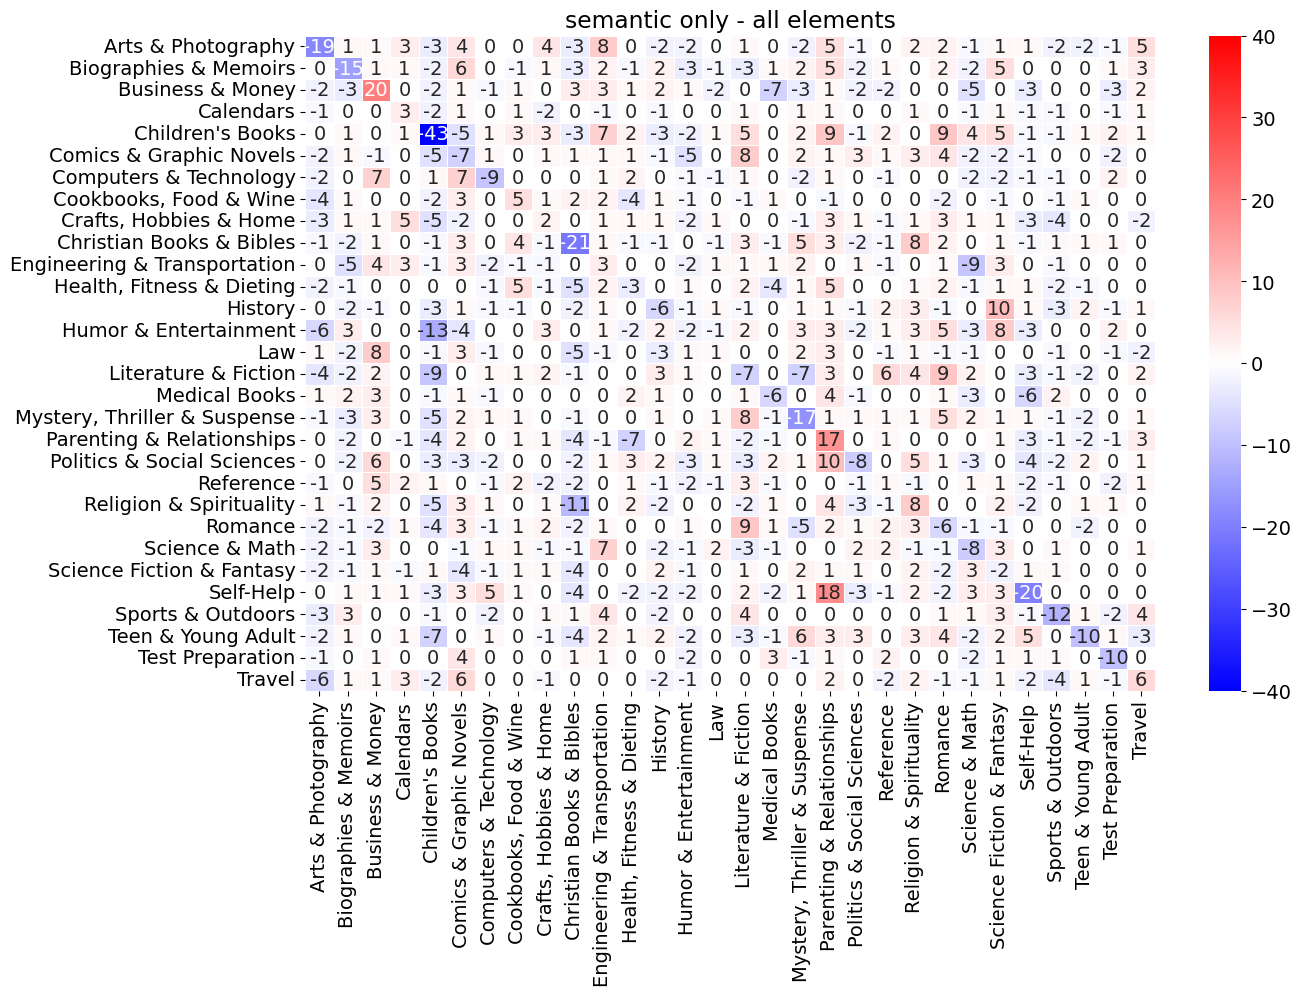

In [9]:
df_test_semantic = pd.read_csv(f'/workspace/{SAVE_ROOT}/font_stylechar_colorbk_colorheightcoord_res.csv')
y_true = df_test_semantic["Category ID"].values
y_pred = df_test_semantic["top1_res"].values
cm_semantic = confusion_matrix(y_true, y_pred)
cm_diff = cm_semantic - cm_all
val_max = 40#np.max([np.max(cm_diff),np.abs(np.min(cm_diff))])
xtics = df_tmp.sort_values("Category ID")['Category'].values
plt.figure(figsize = (14,10))
plt.rcParams["font.size"] = 14
sns.heatmap(cm_diff, cmap='bwr', vmin=-val_max, vmax=val_max ,xticklabels=xtics,yticklabels=xtics, linewidths=.5,annot=True,fmt="d")
plt.tight_layout()
plt.title("semantic only - all elements")
plt.show()

# Analysis of the influence of each element 
## (the blue areas are considered to have been important for estimating that element).
## (confusion matrix w/o some elements - all design element confusion matrix)

=== drop feat: semantic===


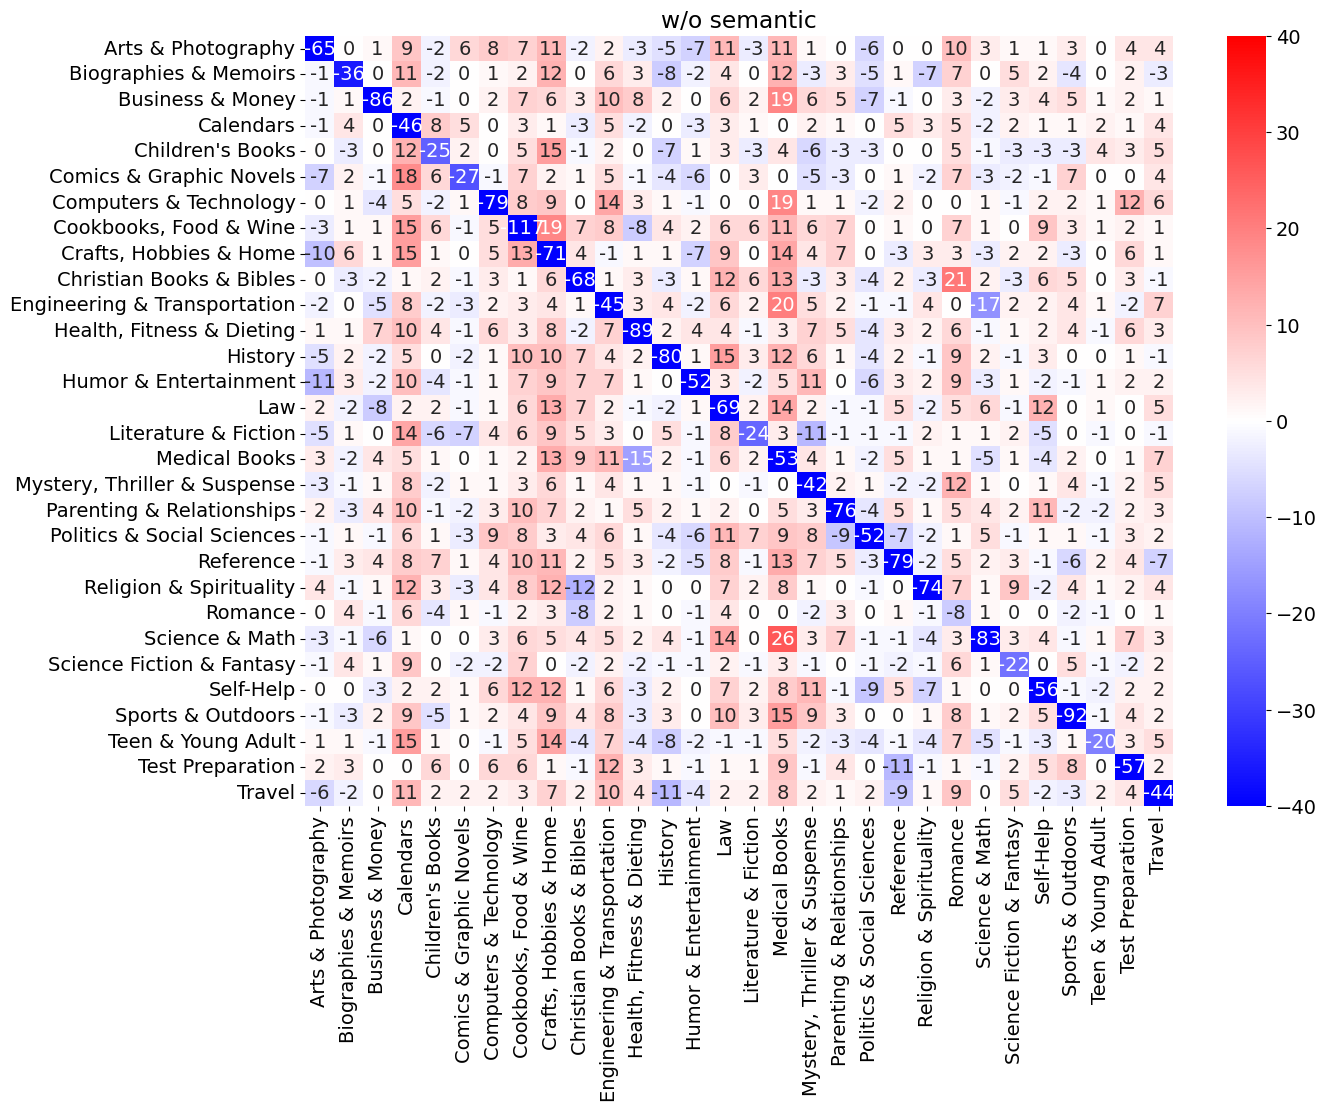

=== drop feat: font_style===


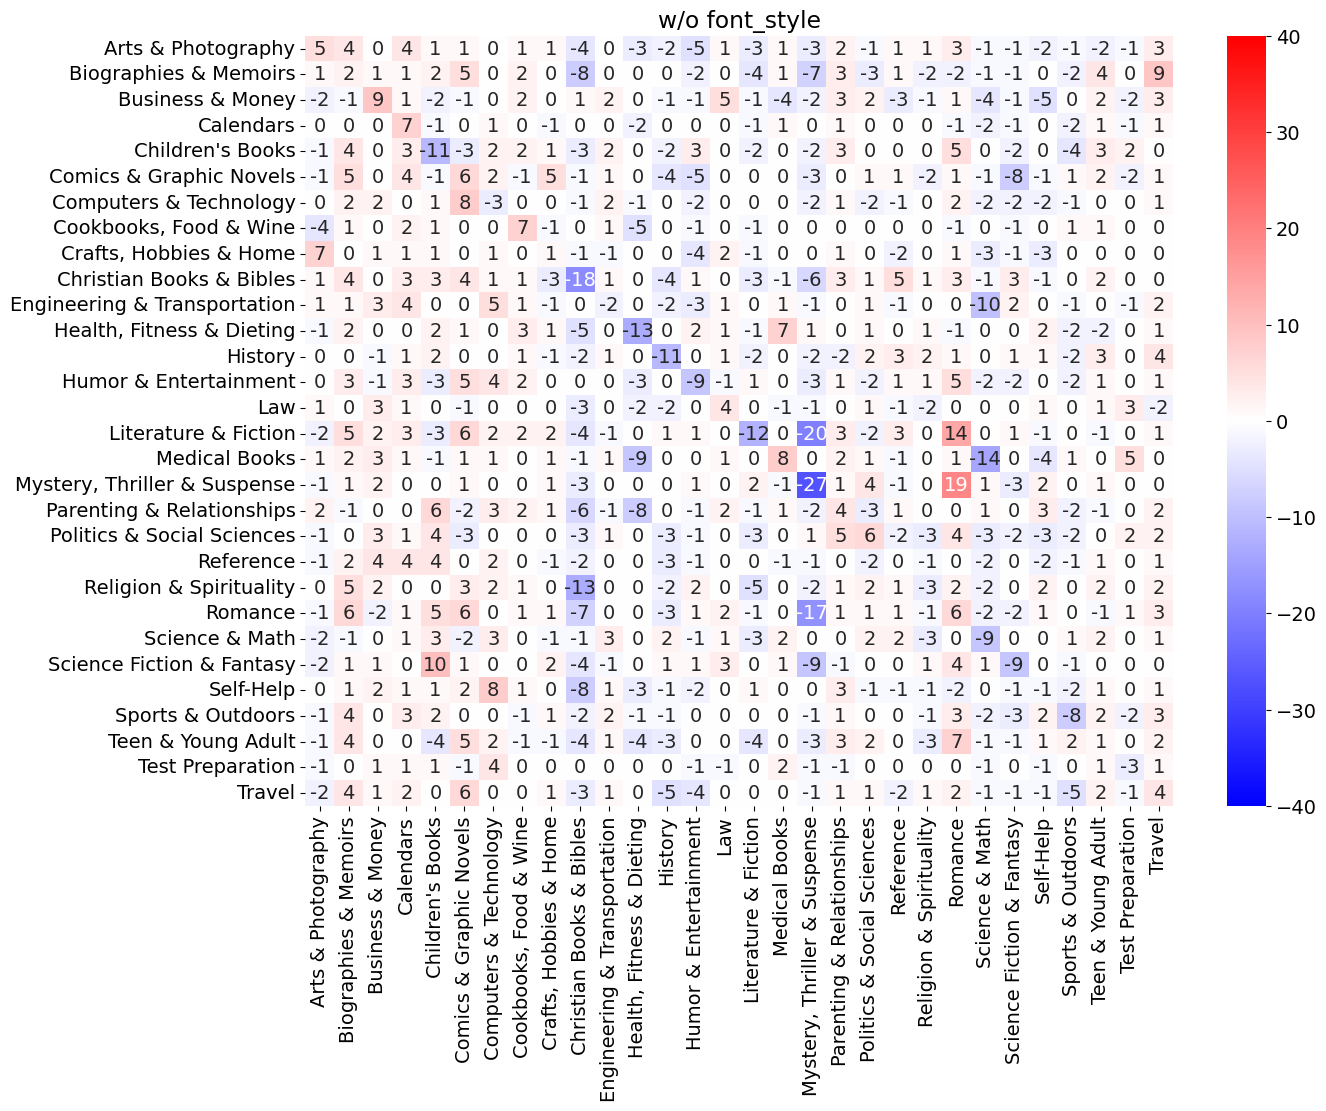

=== drop feat: char_color===


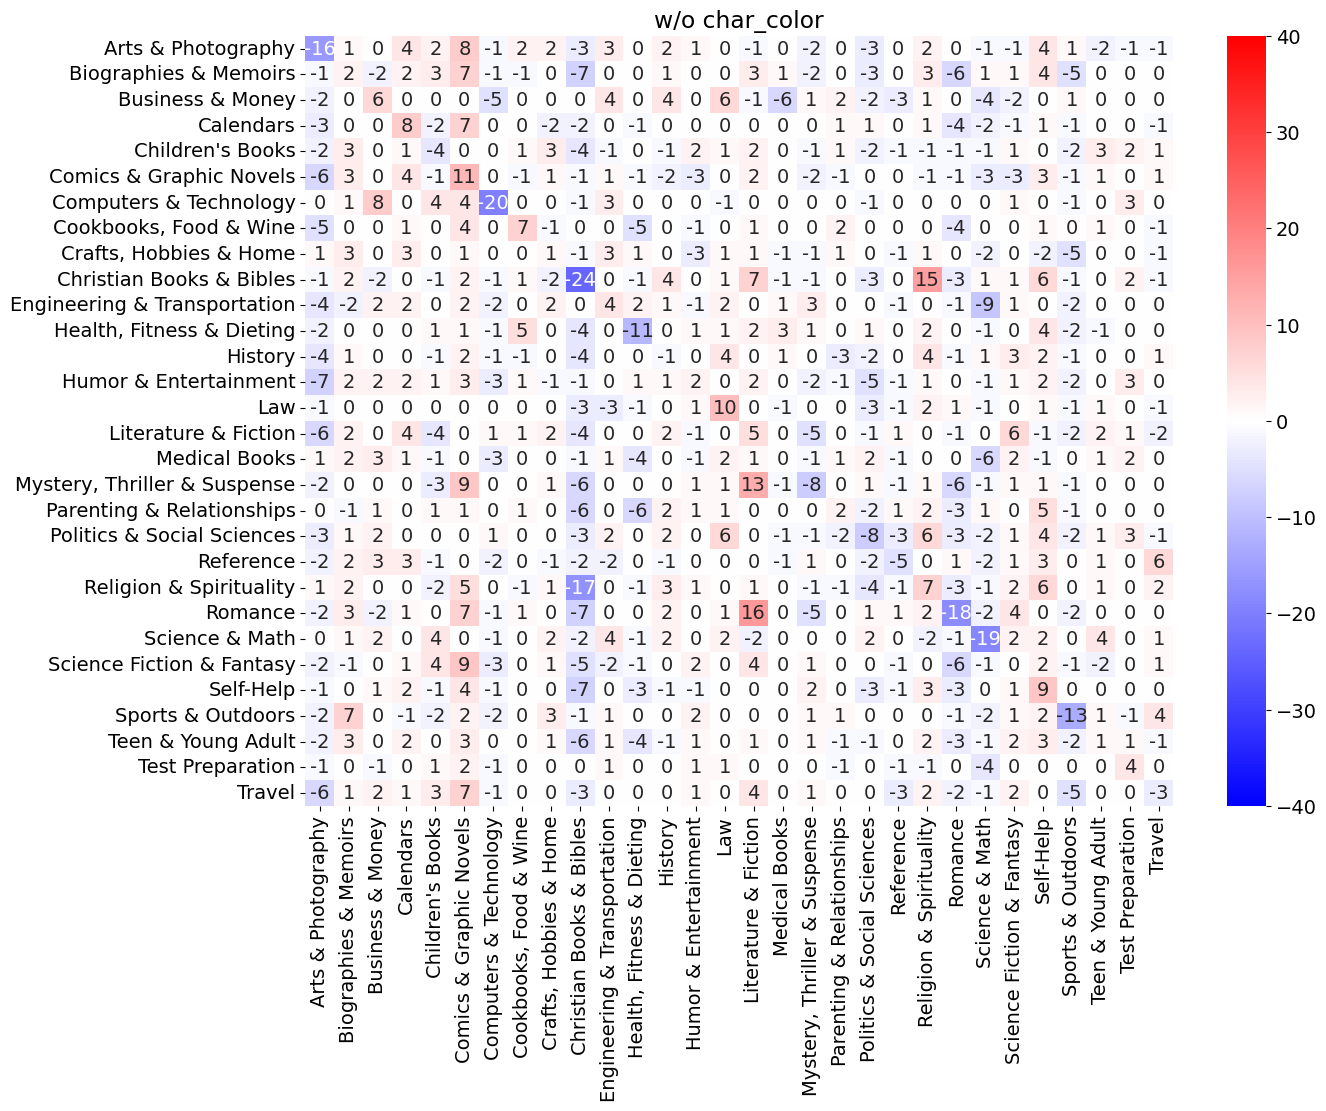

=== drop feat: bk_color===


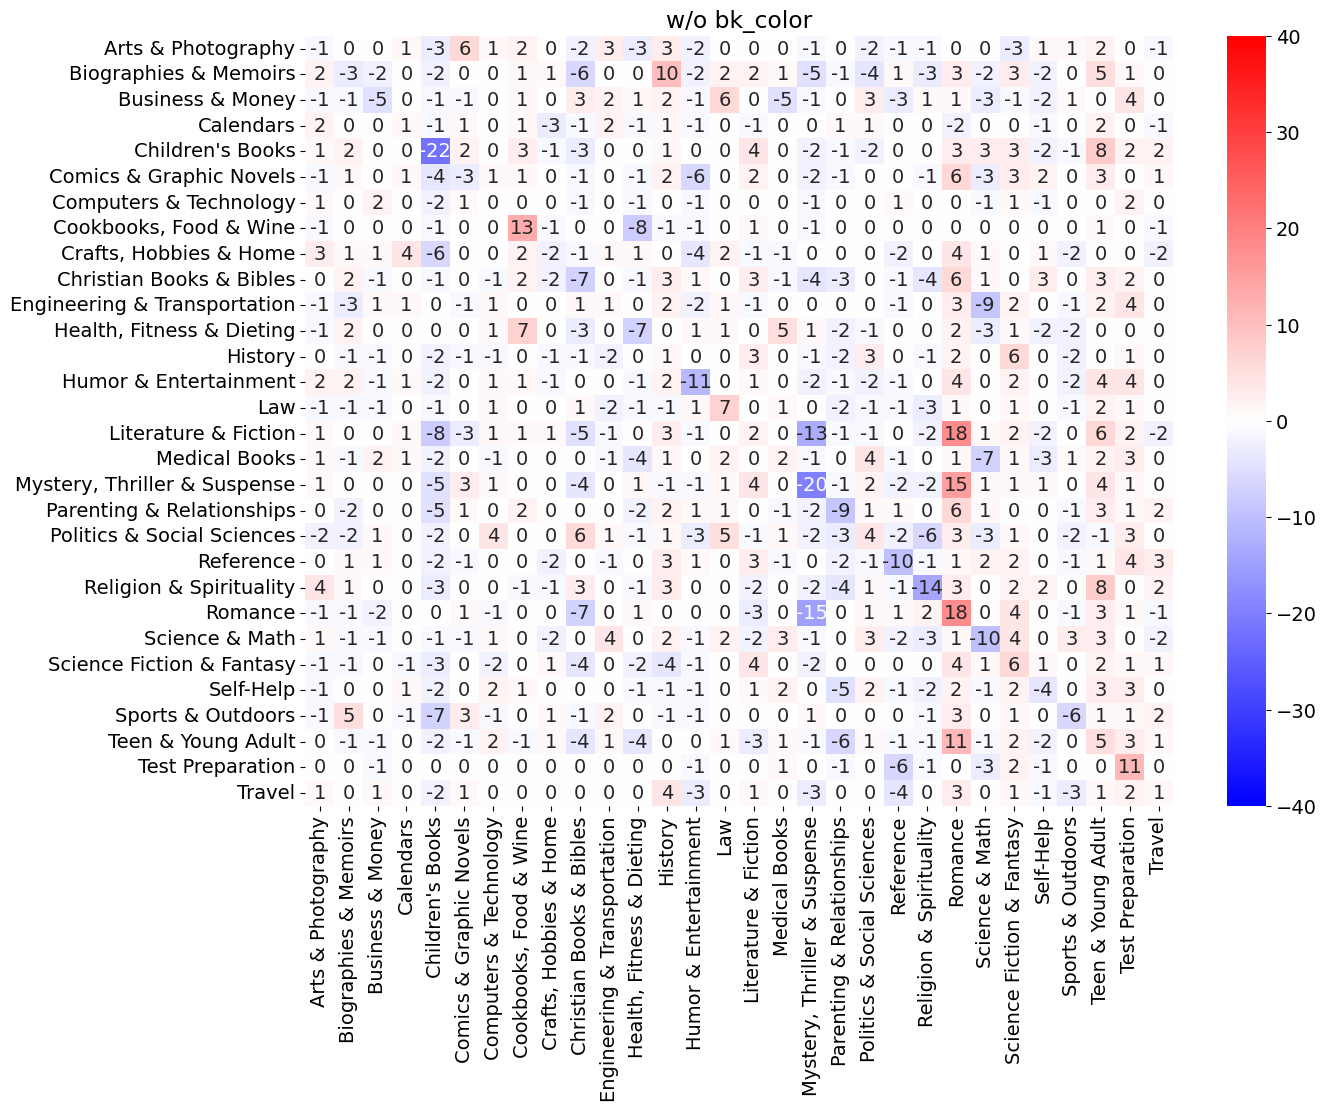

=== drop feat: height===


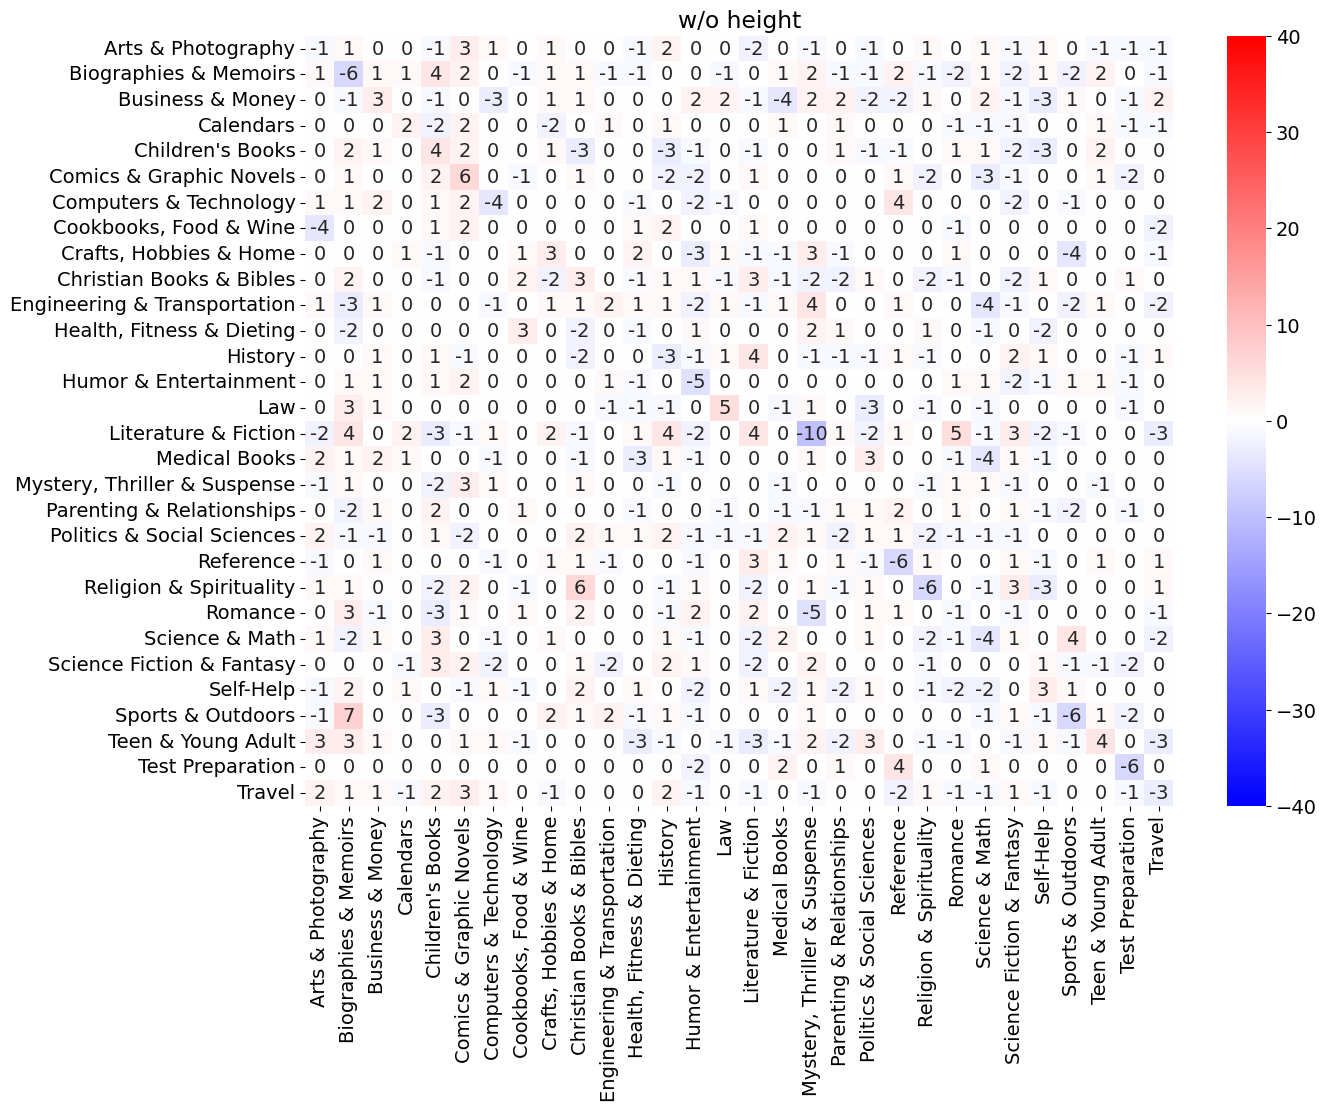

=== drop feat: coord===


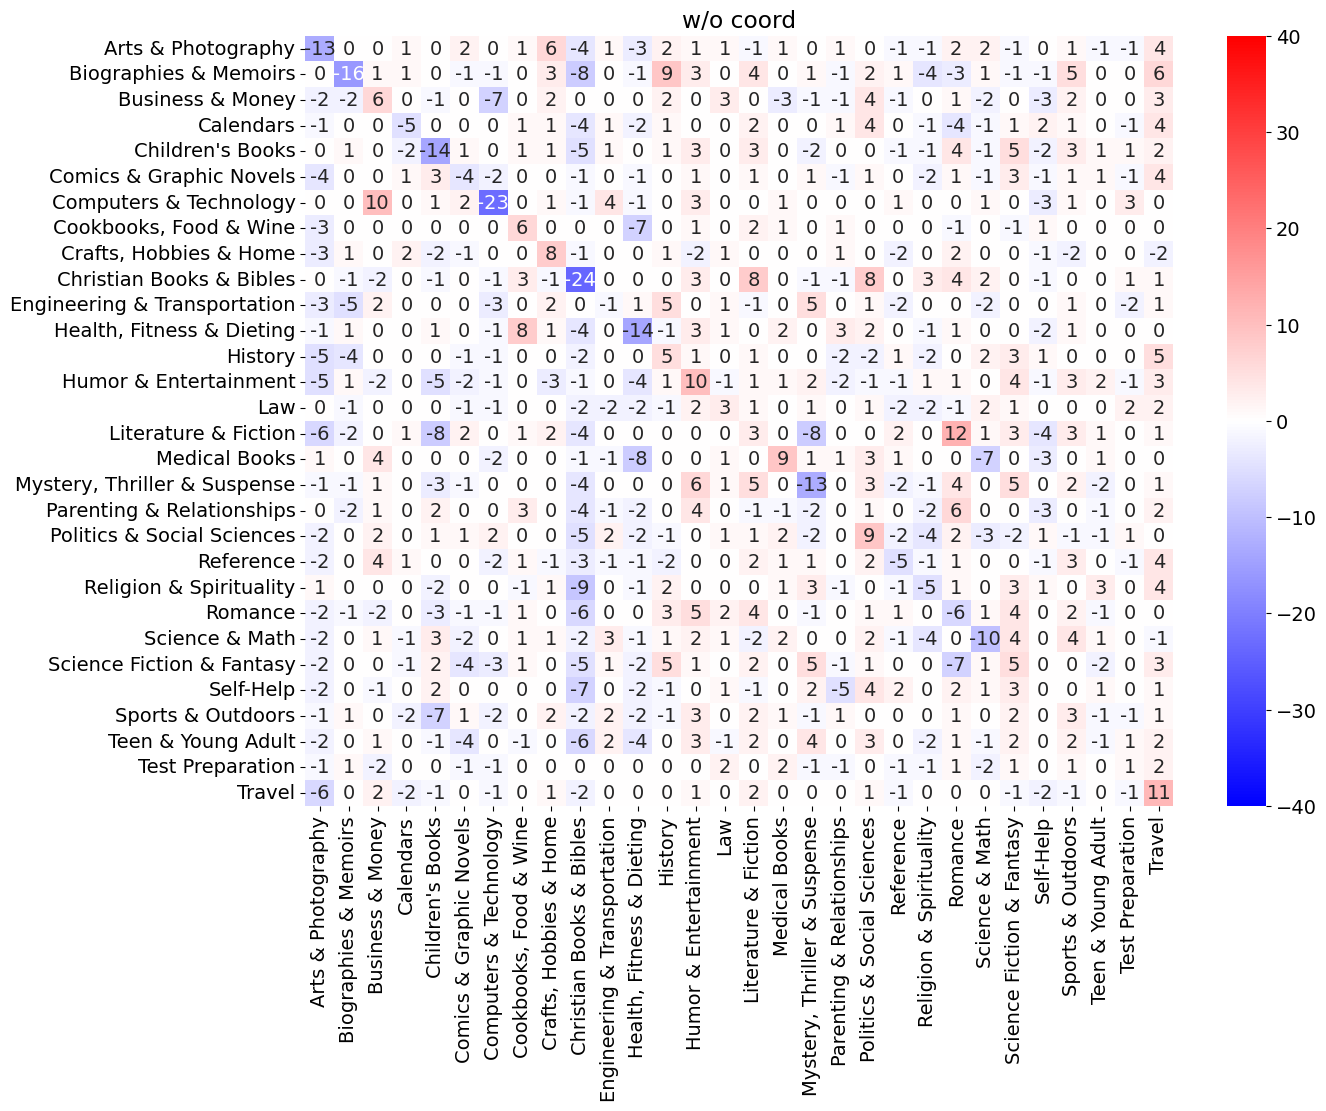

=== drop feat: char_colorbk_color===


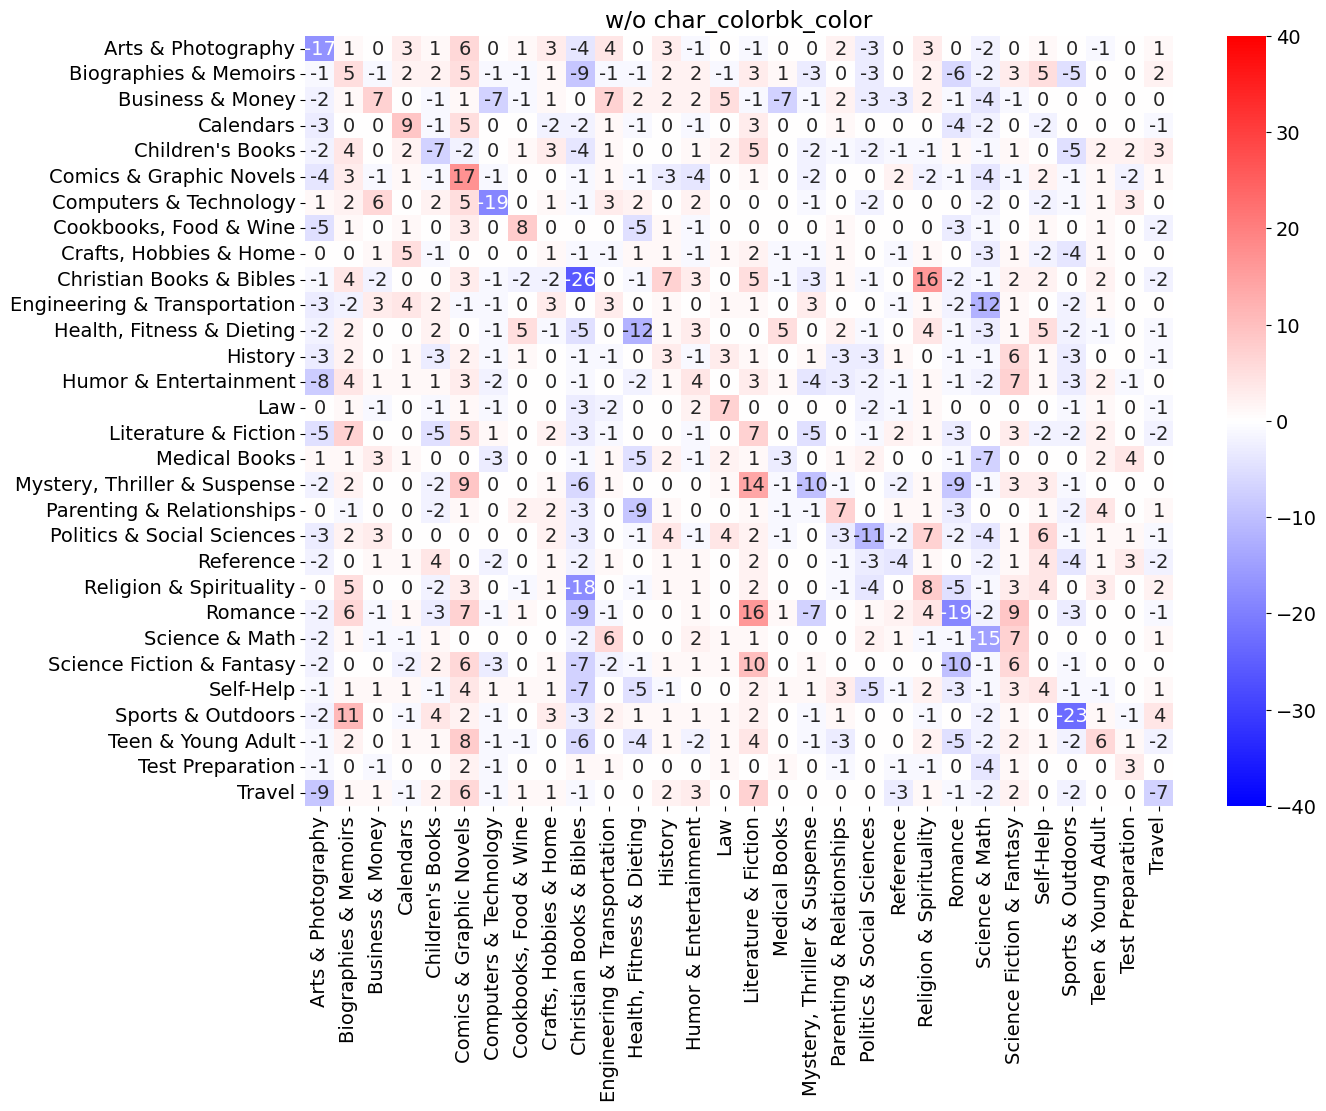

=== drop feat: heightcoord===


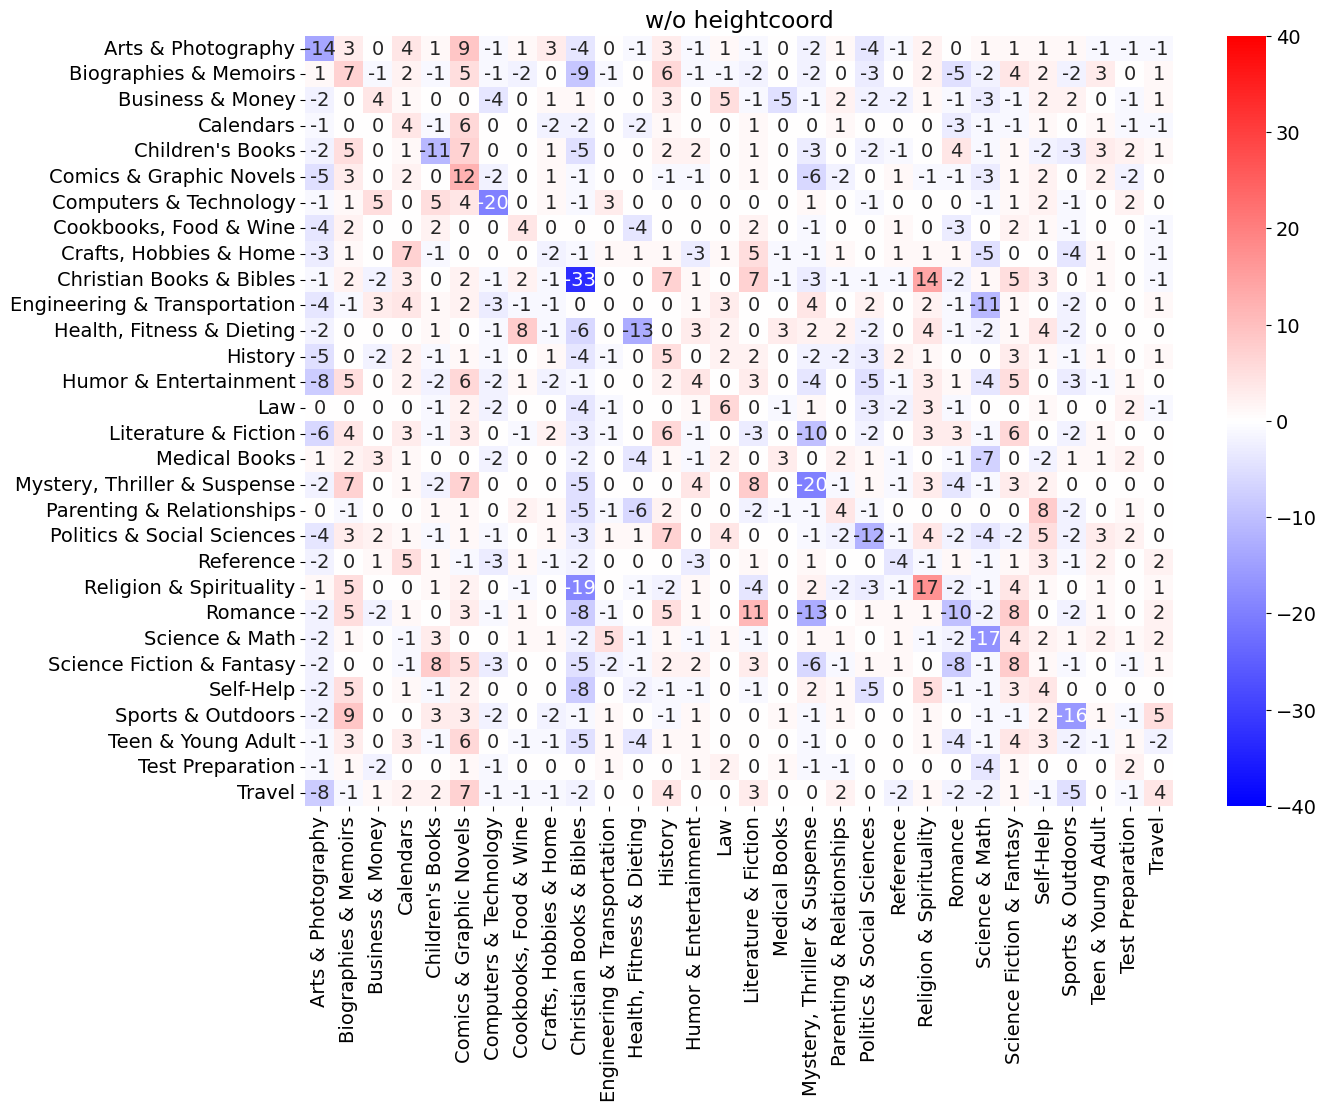

In [10]:
df_res = pd.read_csv(f'/workspace/{SAVE_ROOT}/_res.csv')
df_tmp = df_res[["Category ID","Category"]]
df_tmp = df_tmp[~df_tmp.duplicated()]
y_true = df_res["Category ID"].values
y_pred = df_res["top1_res"].values
cm_all = confusion_matrix(y_true, y_pred)

torch_fix_seed(seed=0)
drop_elements = ["semantic","font_style","char_color","bk_color","height","coord","char_colorbk_color","heightcoord"]
for i in range(len(drop_elements)):
    name = drop_elements[i]
    print(f"=== drop feat: {name}===")
    df_res = pd.read_csv(f'/workspace/{SAVE_ROOT}/csv/{name}_res.csv')
    y_true = df_res["Category ID"].values
    y_pred = df_res["top1_res"].values
    cm = confusion_matrix(y_true, y_pred)
    cm = cm - cm_all
    xtics = df_tmp.sort_values("Category ID")['Category'].values
    plt.figure(figsize = (14,10))
    plt.rcParams["font.size"] = 14
    max_num = 40#np.max([np.max(cm),np.abs(np.min(cm))])
    plt.title("w/o "+name)
    sns.heatmap(cm, cmap='bwr',xticklabels=xtics,yticklabels=xtics,vmax=max_num, vmin=-max_num,annot=True,fmt="d")
    plt.show()